Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import mlflow
import shap
import joblib
import os

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


### Exploratory Data Analysis

Import the datasets

In [2]:
claims_data = pd.read_csv('Data/claims_table.csv')
policy_data = pd.read_csv('Data/policyholder_table.csv')

In [3]:
claims_data.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,Weather_Condition
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,11509.99,2020-06-26,Low,Rainy
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,15470.00,2023-03-21,Low,Rainy
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,13500.00,2023-02-01,Low,Rainy
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,2714.92,2021-12-13,Moderate,Stormy
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,NaN,2022-12-06,Moderate,Rainy


In [4]:
policy_data.head()

,Policy_ID,Customer_ID,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year
0,POL_000001,CUST_77820,1983-04-20,2003-08-23,Sedan,2008
1,POL_000002,CUST_88498,1986-03-10,2007-07-26,Hatchback,2012
2,POL_000003,CUST_60735,1971-03-02,1989-07-05,Hatchback,2021
3,POL_000004,CUST_54707,1946-09-19,1968-01-12,Truck,2022
4,POL_000005,CUST_26658,1957-07-26,1977-08-07,SUV,2006


In [5]:
claims_data.shape

(146987, 11)

In [6]:
policy_data.shape

(120000, 6)

Merging both datasets

In [7]:
claims_data = claims_data.merge(policy_data, on=['Policy_ID', 'Customer_ID'], how='left')

Copying the datasets for EDA and modelling

In [8]:
claims_df = claims_data.copy()
claims_copy = claims_data.copy()

In [9]:
claims_data.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,Weather_Condition,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,11509.99,2020-06-26,Low,Rainy,1983-04-20,2003-08-23,Sedan,2008
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,15470.00,2023-03-21,Low,Rainy,1986-03-10,2007-07-26,Hatchback,2012
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,13500.00,2023-02-01,Low,Rainy,1971-03-02,1989-07-05,Hatchback,2021
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,2714.92,2021-12-13,Moderate,Stormy,1971-03-02,1989-07-05,Hatchback,2021
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,NaN,2022-12-06,Moderate,Rainy,1971-03-02,1989-07-05,Hatchback,2021


In [10]:
claims_data.shape

(146987, 15)

Checking for null values

In [11]:
claims_data.isna().sum()

Claim_ID                      0
Policy_ID                     0
Customer_ID                   0
Accident_Date                 0
FNOL_Date                     0
Claim_Type                    0
Estimated_Claim_Amount     2998
Ultimate_Claim_Amount      2922
Settlement_Date               0
Traffic_Condition          2960
Weather_Condition          3037
Date_of_Birth                 0
Full_License_Issue_Date       0
Vehicle_Type                  0
Vehicle_Year                  0
dtype: int64

In [12]:
claims_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Claim_ID                 146987 non-null  object 
 1   Policy_ID                146987 non-null  object 
 2   Customer_ID              146987 non-null  object 
 3   Accident_Date            146987 non-null  object 
 4   FNOL_Date                146987 non-null  object 
 5   Claim_Type               146987 non-null  object 
 6   Estimated_Claim_Amount   143989 non-null  float64
 7   Ultimate_Claim_Amount    144065 non-null  float64
 8   Settlement_Date          146987 non-null  object 
 9   Traffic_Condition        144027 non-null  object 
 10  Weather_Condition        143950 non-null  object 
 11  Date_of_Birth            146987 non-null  object 
 12  Full_License_Issue_Date  146987 non-null  object 
 13  Vehicle_Type             146987 non-null  object 
 14  Vehi

In [13]:
print("=" * 50)
print("Columns with missing values and their data types:")
print("=" * 50)
for i in range(len(claims_data.columns)):
    if claims_data[claims_data.columns[i]].isna().sum() > 0:
        # print(claims_data.columns[i], claims_data[claims_data.columns[i]].isna().sum())
        print(claims_data.columns[i], "*** Data type - ", claims_data[claims_data.columns[i]].dtype)

Columns with missing values and their data types:
Estimated_Claim_Amount *** Data type -  float64
Ultimate_Claim_Amount *** Data type -  float64
Traffic_Condition *** Data type -  object
Weather_Condition *** Data type -  object


In [14]:
# fill categorial missing values with mode
categorical_cols = claims_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    mode_value = claims_data[col].mode()[0]
    claims_data[col].fillna(mode_value, inplace=True)

In [15]:
# fill numerical missing values with median
numerical_cols = claims_data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    median_value = claims_data[col].median()
    claims_data[col].fillna(median_value, inplace=True)

In [16]:
claims_data.isna().sum()

Claim_ID                   0
Policy_ID                  0
Customer_ID                0
Accident_Date              0
FNOL_Date                  0
Claim_Type                 0
Estimated_Claim_Amount     0
Ultimate_Claim_Amount      0
Settlement_Date            0
Traffic_Condition          0
Weather_Condition          0
Date_of_Birth              0
Full_License_Issue_Date    0
Vehicle_Type               0
Vehicle_Year               0
dtype: int64

In [17]:
claims_data.shape

(146987, 15)

Visualising the frequncy of the different weather, traffic, vehicles and claims types in the data

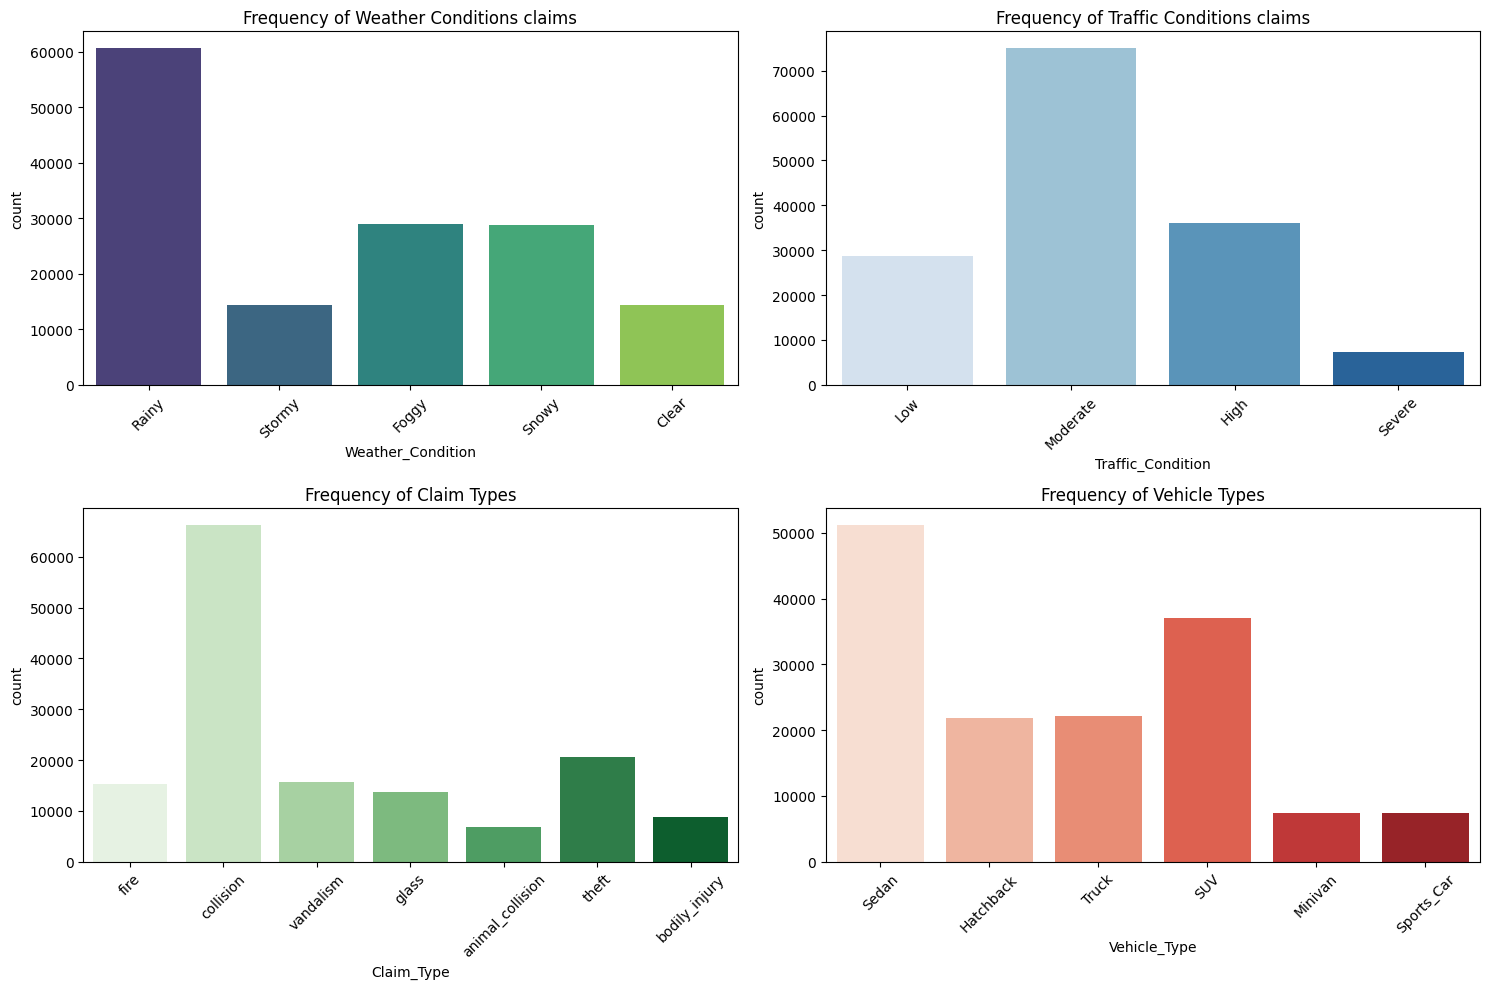

In [18]:
#Visualise weather, traffic conditions, claim and vehicle types frequencies
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.countplot(x='Weather_Condition', data=claims_data, palette='viridis')
plt.title('Frequency of Weather Conditions claims')
plt.xticks(rotation=45)

plt.subplot(2,2,2)
sns.countplot(x='Traffic_Condition', data=claims_data, palette='Blues')
plt.title('Frequency of Traffic Conditions claims')
plt.xticks(rotation = 45)

plt.subplot(2,2,3)
sns.countplot(x='Claim_Type', data=claims_data, palette='Greens')
plt.title('Frequency of Claim Types')
plt.xticks(rotation = 45)

plt.subplot(2,2,4)
sns.countplot(x='Vehicle_Type', data=claims_data, palette='Reds')
plt.title('Frequency of Vehicle Types')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

Converting the date columns to datetime format for easier manipulation

In [19]:
claims_data['FNOL_Date'] = pd.to_datetime(claims_data['FNOL_Date'])
claims_data['Accident_Date'] = pd.to_datetime(claims_data['Accident_Date'])
claims_data['Date_of_Birth'] = pd.to_datetime(claims_data['Date_of_Birth'])
claims_data['Full_License_Issue_Date'] = pd.to_datetime(claims_data['Full_License_Issue_Date'])
claims_data['Settlement_Date'] = pd.to_datetime(claims_data['Settlement_Date'])
claims_data['Vehicle_Year'] = pd.to_datetime(claims_data['Vehicle_Year'], format='%Y')
claims_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Claim_ID                 146987 non-null  object        
 1   Policy_ID                146987 non-null  object        
 2   Customer_ID              146987 non-null  object        
 3   Accident_Date            146987 non-null  datetime64[ns]
 4   FNOL_Date                146987 non-null  datetime64[ns]
 5   Claim_Type               146987 non-null  object        
 6   Estimated_Claim_Amount   146987 non-null  float64       
 7   Ultimate_Claim_Amount    146987 non-null  float64       
 8   Settlement_Date          146987 non-null  datetime64[ns]
 9   Traffic_Condition        146987 non-null  object        
 10  Weather_Condition        146987 non-null  object        
 11  Date_of_Birth            146987 non-null  datetime64[ns]
 12  Full_License_Iss

Visualising the trends of claims over time

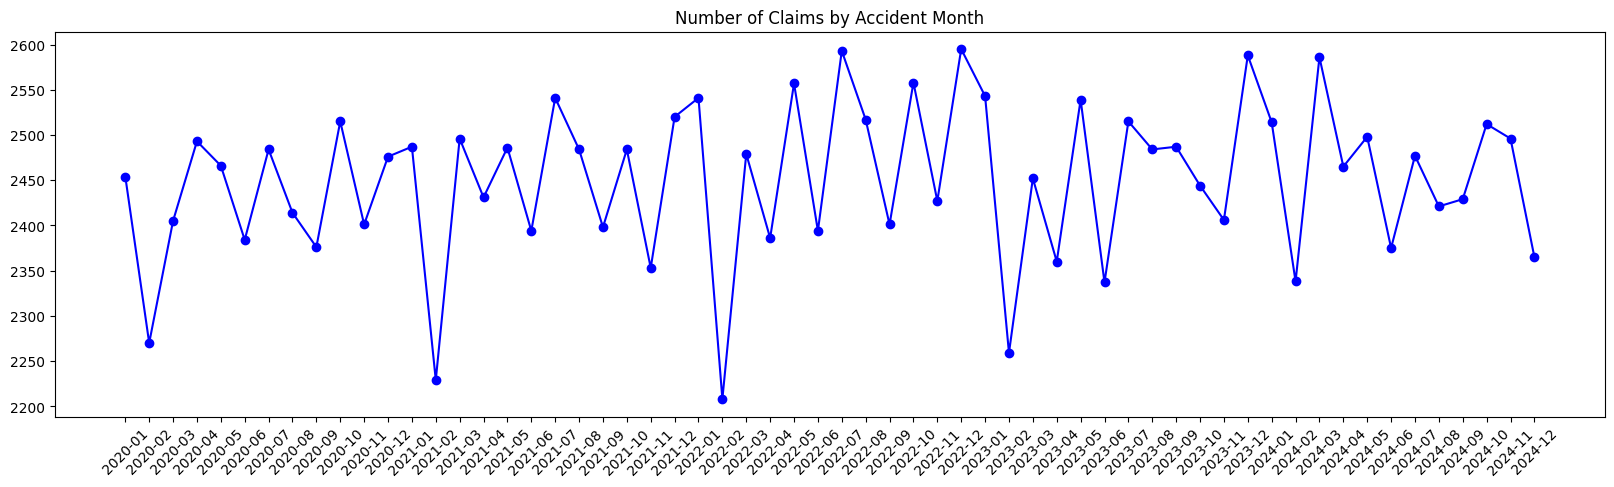

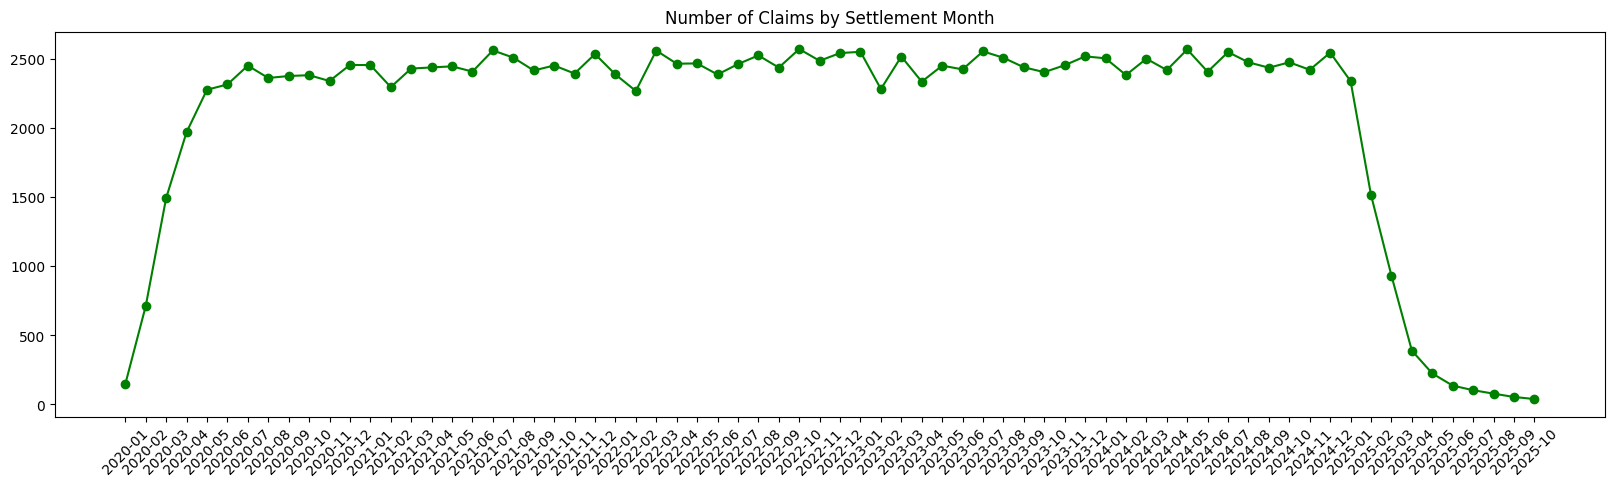

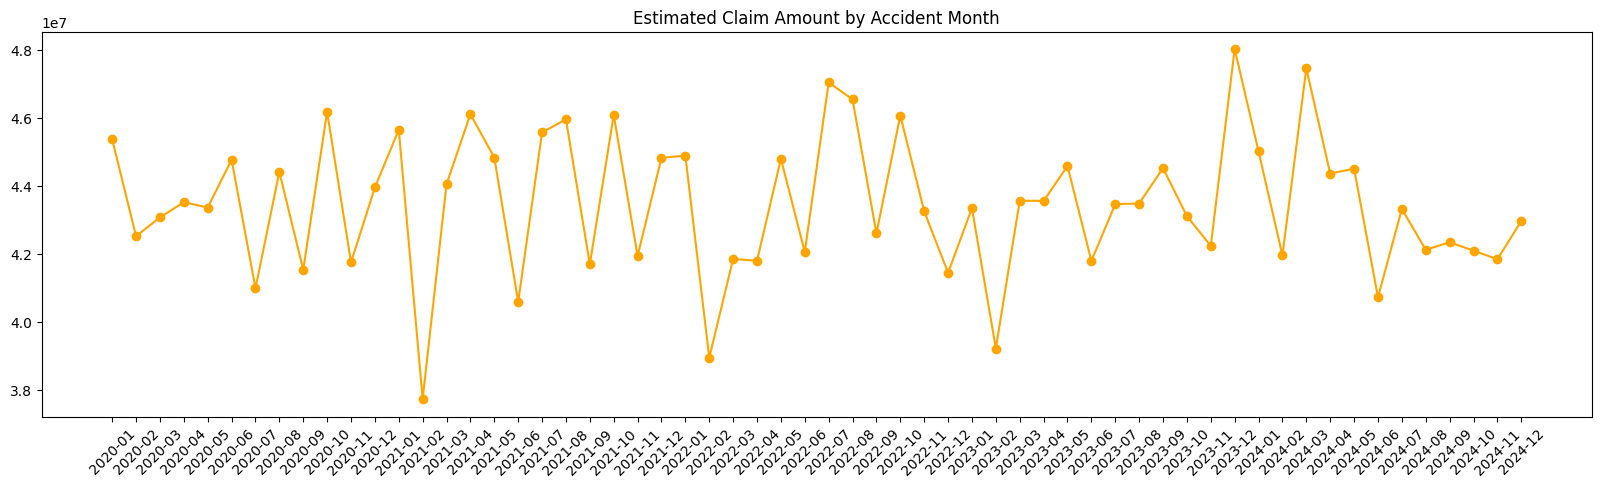

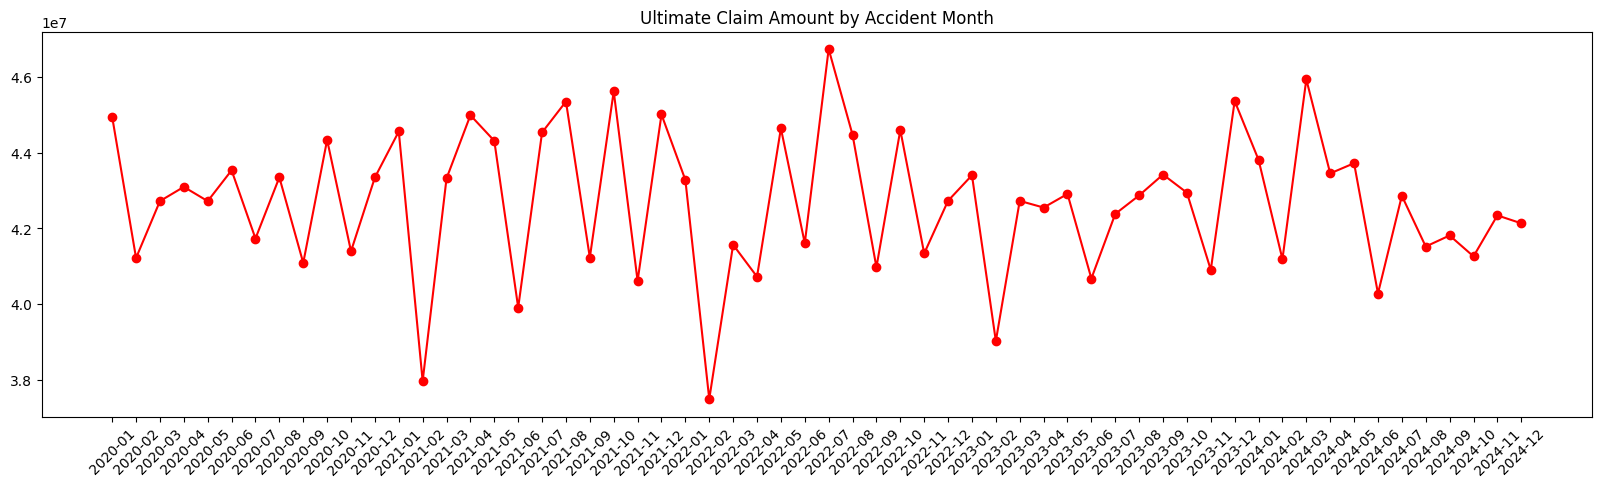

In [20]:
claims_data['Accident_month'] = claims_data['Accident_Date'].dt.to_period('M')
claims_data['Accident_day'] = claims_data['Accident_Date'].dt.day_name()

claims_data['Settlement_month'] = claims_data['Settlement_Date'].dt.to_period('M')
claims_data['Settlement_day'] = claims_data['Settlement_Date'].dt.day_name()

accident_month = claims_data.groupby('Accident_month').agg({
    'Claim_ID':'count',
    'Estimated_Claim_Amount':'sum',
    'Ultimate_Claim_Amount':'sum',
    'Customer_ID':'nunique',
    'Policy_ID':'nunique'
}).round(2)

settlement_month = claims_data.groupby('Settlement_month').agg({
    'Claim_ID':'count',
    'Estimated_Claim_Amount':'sum',
    'Ultimate_Claim_Amount':'sum',
    'Customer_ID':'nunique',
    'Policy_ID':'nunique'
    }).round(2)

accident_month.columns = ['Claim_ID', 'Estimated_Claim_Amount', 'Ultimate_Claim_Amount', 'Customer_ID', 'Policy_ID']
settlement_month.columns = ['Claim_ID', 'Estimated_Claim_Amount', 'Ultimate_Claim_Amount', 'Customer_ID', 'Policy_ID']

plt.figure(figsize=(20,5))
plt.plot(accident_month.index.astype(str), accident_month['Claim_ID'], marker='o', color='blue')
plt.title('Number of Claims by Accident Month')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(settlement_month.index.astype(str), settlement_month['Claim_ID'], marker='o', color='green')
plt.title('Number of Claims by Settlement Month')
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(20,5))
plt.plot(accident_month.index.astype(str), accident_month['Estimated_Claim_Amount'], marker='o', color='orange')
plt.title('Estimated Claim Amount by Accident Month')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(accident_month.index.astype(str), accident_month['Ultimate_Claim_Amount'], marker='o', color='red')
plt.title('Ultimate Claim Amount by Accident Month')
plt.xticks(rotation=45)
plt.show()

Visualsing the effects  of weather, traffic, claims and vehicle types on  ultimate claim amounts

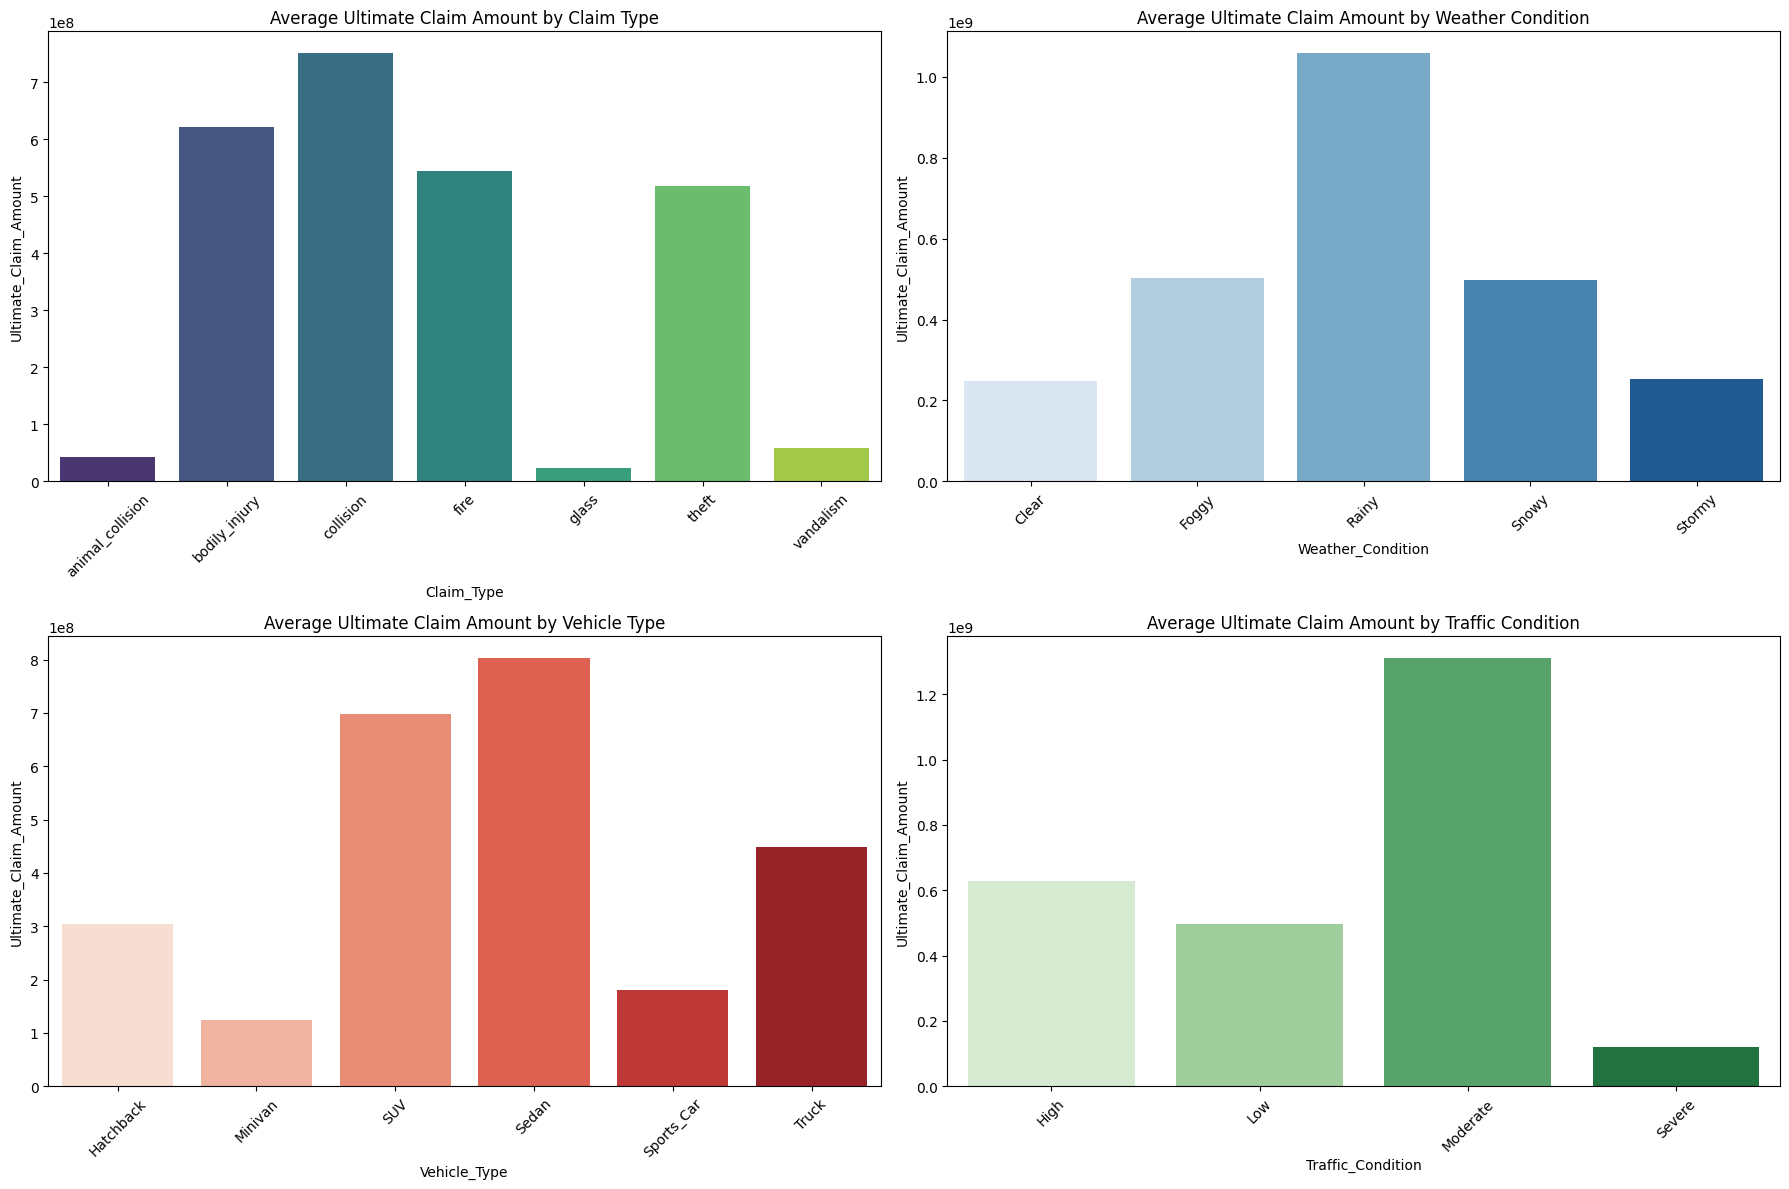

In [21]:
# Visualise the effect of claim types, weather conditions, traffic and vehicle type on ultimate claim amount

claims_type = claims_data.groupby('Claim_Type').agg({
    'Claim_ID':'count',
    'Ultimate_Claim_Amount':'sum'
}).round(2)

weather_condition = claims_data.groupby('Weather_Condition').agg({
    'Claim_ID':'count',
    'Ultimate_Claim_Amount':'sum'
}).round(2)

vehicle_type = claims_data.groupby('Vehicle_Type').agg({
    'Claim_ID':'count',
    'Ultimate_Claim_Amount':'sum'
}).round(2)

traffic_condition = claims_data.groupby('Traffic_Condition').agg({
    'Claim_ID':'count',
    'Ultimate_Claim_Amount':'sum'
}).round(2)

claims_type.columns = ['Claim_ID', 'Ultimate_Claim_Amount']
weather_condition.columns = ['Claim_ID', 'Ultimate_Claim_Amount']
vehicle_type.columns = ['Claim_ID', 'Ultimate_Claim_Amount']
traffic_condition.columns = ['Claim_ID', 'Ultimate_Claim_Amount']
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
sns.barplot(x=claims_type.index, y='Ultimate_Claim_Amount', data=claims_type, palette='viridis')
plt.title('Average Ultimate Claim Amount by Claim Type')
plt.xticks(rotation=45)

plt.subplot(2,2,2)
sns.barplot(x=weather_condition.index, y='Ultimate_Claim_Amount', data=weather_condition, palette='Blues')
plt.title('Average Ultimate Claim Amount by Weather Condition')
plt.xticks(rotation=45)

plt.subplot(2,2,3)
sns.barplot(x=vehicle_type.index, y='Ultimate_Claim_Amount', data=vehicle_type, palette='Reds')
plt.title('Average Ultimate Claim Amount by Vehicle Type')
plt.xticks(rotation=45)

plt.subplot(2,2,4)
sns.barplot(x=traffic_condition.index, y='Ultimate_Claim_Amount', data=traffic_condition, palette='Greens')
plt.title('Average Ultimate Claim Amount by Traffic Condition')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Data Preprocessing

In [22]:
claims_df.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,Weather_Condition,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,11509.99,2020-06-26,Low,Rainy,1983-04-20,2003-08-23,Sedan,2008
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,15470.00,2023-03-21,Low,Rainy,1986-03-10,2007-07-26,Hatchback,2012
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,13500.00,2023-02-01,Low,Rainy,1971-03-02,1989-07-05,Hatchback,2021
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,2714.92,2021-12-13,Moderate,Stormy,1971-03-02,1989-07-05,Hatchback,2021
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,NaN,2022-12-06,Moderate,Rainy,1971-03-02,1989-07-05,Hatchback,2021


In [23]:
claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Claim_ID                 146987 non-null  object 
 1   Policy_ID                146987 non-null  object 
 2   Customer_ID              146987 non-null  object 
 3   Accident_Date            146987 non-null  object 
 4   FNOL_Date                146987 non-null  object 
 5   Claim_Type               146987 non-null  object 
 6   Estimated_Claim_Amount   143989 non-null  float64
 7   Ultimate_Claim_Amount    144065 non-null  float64
 8   Settlement_Date          146987 non-null  object 
 9   Traffic_Condition        144027 non-null  object 
 10  Weather_Condition        143950 non-null  object 
 11  Date_of_Birth            146987 non-null  object 
 12  Full_License_Issue_Date  146987 non-null  object 
 13  Vehicle_Type             146987 non-null  object 
 14  Vehi

In [24]:
# converting date columns to datetime
claims_df['FNOL_Date'] = pd.to_datetime(claims_df['FNOL_Date'])
claims_df['Accident_Date'] = pd.to_datetime(claims_df['Accident_Date'])
claims_df['Date_of_Birth'] = pd.to_datetime(claims_df['Date_of_Birth'])
claims_df['Full_License_Issue_Date'] = pd.to_datetime(claims_df['Full_License_Issue_Date'])
claims_df['Settlement_Date'] = pd.to_datetime(claims_df['Settlement_Date'])
claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Claim_ID                 146987 non-null  object        
 1   Policy_ID                146987 non-null  object        
 2   Customer_ID              146987 non-null  object        
 3   Accident_Date            146987 non-null  datetime64[ns]
 4   FNOL_Date                146987 non-null  datetime64[ns]
 5   Claim_Type               146987 non-null  object        
 6   Estimated_Claim_Amount   143989 non-null  float64       
 7   Ultimate_Claim_Amount    144065 non-null  float64       
 8   Settlement_Date          146987 non-null  datetime64[ns]
 9   Traffic_Condition        144027 non-null  object        
 10  Weather_Condition        143950 non-null  object        
 11  Date_of_Birth            146987 non-null  datetime64[ns]
 12  Full_License_Iss

In [25]:
# calculate driver age using Date_of_Birth and Accident_Date
claims_df['Driver_Age'] = claims_df.apply(lambda row: (row['Accident_Date'] - row['Date_of_Birth']).days // 365, axis=1)

# calculate license years using Full_License_Issue_Date and Accident_Date
claims_df['License_Years'] = claims_df.apply(lambda row: (row['Accident_Date'] - row['Full_License_Issue_Date']).days // 365, axis=1)

# calculate FNOL to accident days
claims_df['FNOL_delay'] = (claims_df['FNOL_Date'] - claims_df['Accident_Date']).dt.days

# calculate FNOL to settlement days
claims_df['Settlement_Days'] = (claims_df['Settlement_Date'] - claims_df['FNOL_Date']).dt.days

claims_df.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,Weather_Condition,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year,Driver_Age,License_Years,FNOL_delay,Settlement_Days
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,11509.99,2020-06-26,Low,Rainy,1983-04-20,2003-08-23,Sedan,2008,36,16,4,112
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,15470.00,2023-03-21,Low,Rainy,1986-03-10,2007-07-26,Hatchback,2012,36,15,1,70
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,13500.00,2023-02-01,Low,Rainy,1971-03-02,1989-07-05,Hatchback,2021,51,33,1,37
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,2714.92,2021-12-13,Moderate,Stormy,1971-03-02,1989-07-05,Hatchback,2021,50,32,5,14
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,NaN,2022-12-06,Moderate,Rainy,1971-03-02,1989-07-05,Hatchback,2021,51,33,7,59


In [26]:
missing_values = claims_df.columns[claims_df.isna().sum() > 0]

for col in missing_values:
    print(f"{col}: {claims_df[col].dtype}")

Estimated_Claim_Amount: float64
Ultimate_Claim_Amount: float64
Traffic_Condition: object
Weather_Condition: object


In [27]:
# fill numerical missing values with median
for col in ['Estimated_Claim_Amount', 'Ultimate_Claim_Amount']:
    median_value = claims_df[col].median()
    claims_df[col].fillna(median_value, inplace=True)

# fill categorical missing values with mode
for col in ['Traffic_Condition', 'Weather_Condition']:
    mode_value = claims_df[col].mode()[0]
    claims_df[col].fillna(mode_value, inplace=True)

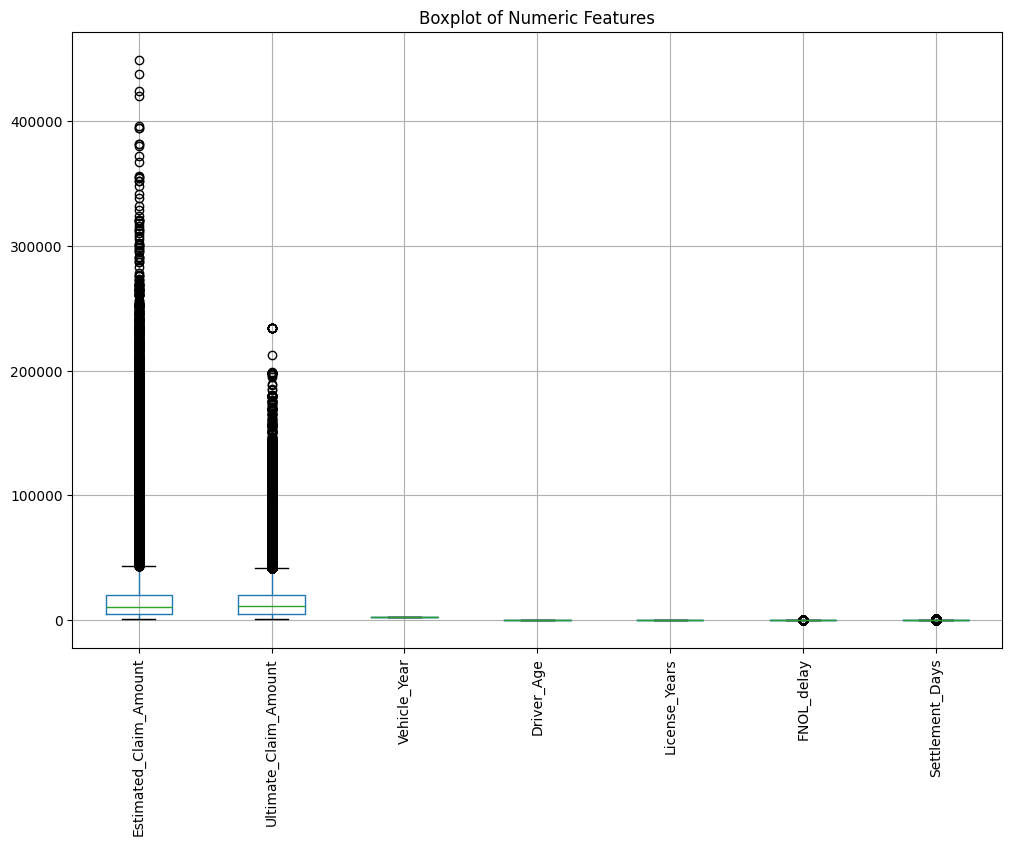

In [28]:
numeric_features = claims_df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12,8))
claims_df[numeric_features].boxplot(rot=90)
plt.title('Boxplot of Numeric Features')
plt.show()

In [29]:
# Initial statistical analysis

print("=" * 50)
print("Statistical Summary of Numerical Columns:")
print("=" * 50)
print(f"Minimum Ultimate Claim Amount: {claims_df['Ultimate_Claim_Amount'].min()}")
print(f"Maximum Ultimate Claim Amount: {claims_df['Ultimate_Claim_Amount'].max()}")

print("\n" + "=" * 50)

print("Minimum Age of Drivers:", claims_df['Driver_Age'].min())
print("Maximum Age of Drivers:", claims_df['Driver_Age'].max())
print("Average Age of Drivers:", claims_df['Driver_Age'].mean().round(2))
print("Median Age of Drivers:", claims_df['Driver_Age'].median())

print("\n" + "=" * 50)

print("Claim with highest Ultimate Claim Amount:", claims_df['Claim_Type'].loc[claims_df['Ultimate_Claim_Amount'].idxmax()])

print("\n" + "=" * 50)
print("Most Freequnet Weather Condition during claims:", claims_df['Weather_Condition'].mode()[0])
print("Most Freequnet Traffic Condition during claims:", claims_df['Traffic_Condition'].mode()[0])


Statistical Summary of Numerical Columns:
Minimum Ultimate Claim Amount: 450.0
Maximum Ultimate Claim Amount: 234000.0

Minimum Age of Drivers: 18
Maximum Age of Drivers: 84
Average Age of Drivers: 50.96
Median Age of Drivers: 51.0

Claim with highest Ultimate Claim Amount: bodily_injury

Most Freequnet Weather Condition during claims: Rainy
Most Freequnet Traffic Condition during claims: Moderate


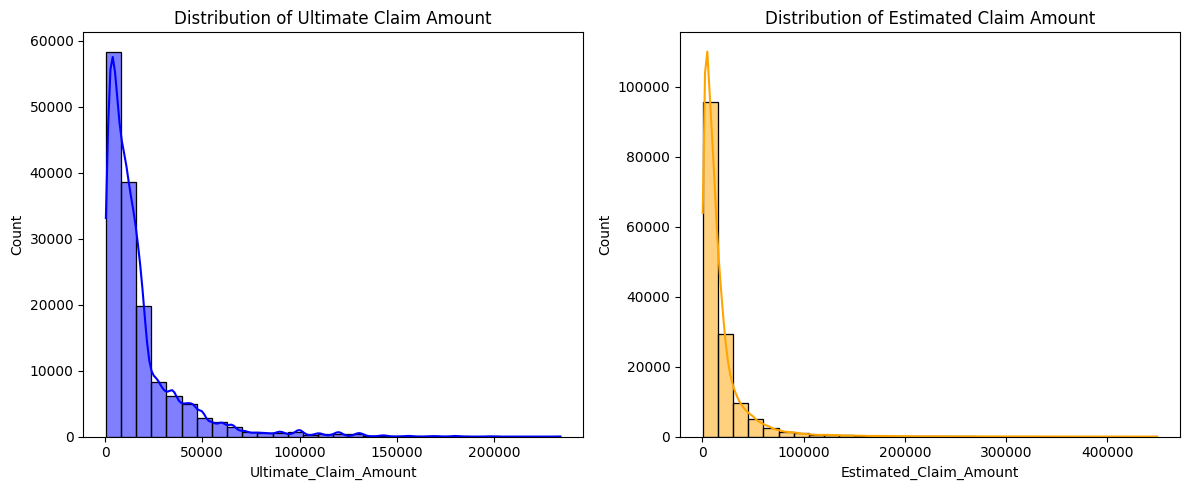

In [30]:
# Histogram of Ultimate Claim Amount and Estimated Claim Amount
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(claims_df['Ultimate_Claim_Amount'], bins=30, kde=True, color='blue')
plt.title('Distribution of Ultimate Claim Amount')

plt.subplot(1,2,2)
sns.histplot(claims_df['Estimated_Claim_Amount'], bins=30, kde=True, color='orange')
plt.title('Distribution of Estimated Claim Amount')

plt.tight_layout()
plt.show()

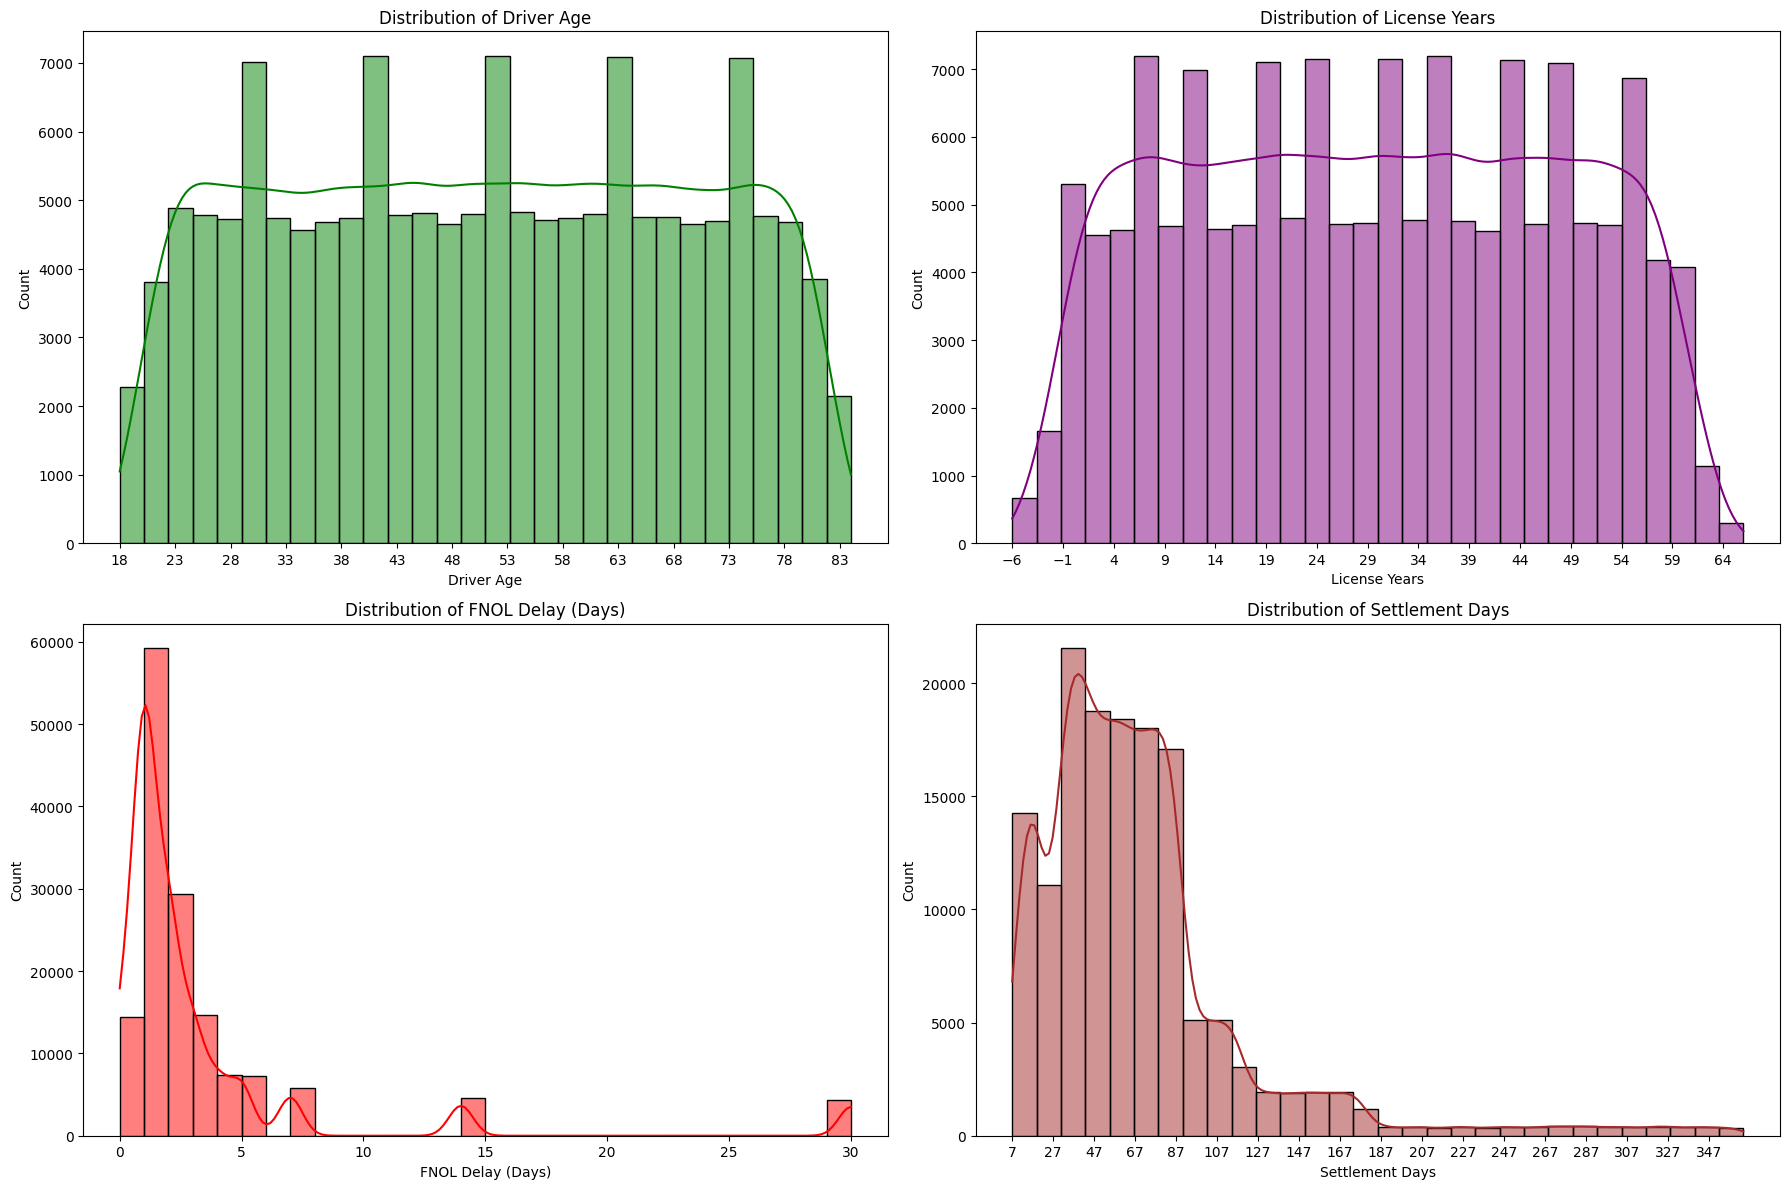

In [31]:
# Visualize Driver Age, License Duration FNOL delay and Settlement days distribution 

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
sns.histplot(claims_df['Driver_Age'], bins=30, kde=True, color='green')
plt.xlabel('Driver Age')
plt.xticks(range(claims_df['Driver_Age'].min(), claims_df['Driver_Age'].max()+1, 5))
plt.title('Distribution of Driver Age')

plt.subplot(2,2,2)
sns.histplot(claims_df['License_Years'], bins=30, kde=True, color='purple')
plt.xlabel('License Years')
plt.xticks(range(claims_df['License_Years'].min(), claims_df['License_Years'].max()+1, 5))
plt.title('Distribution of License Years')

plt.subplot(2,2,3)
sns.histplot(claims_df['FNOL_delay'], bins=30, kde=True, color='red')
plt.xlabel('FNOL Delay (Days)')
plt.xticks(range(claims_df['FNOL_delay'].min(), claims_df['FNOL_delay'].max()+1, 5))
plt.title('Distribution of FNOL Delay (Days)')

plt.subplot(2,2,4)
sns.histplot(claims_df['Settlement_Days'], bins=30, kde=True, color='brown')
plt.xlabel('Settlement Days')
plt.xticks(range(claims_df['Settlement_Days'].min(), claims_df['Settlement_Days'].max()+1, 20))
plt.title('Distribution of Settlement Days')

plt.tight_layout()
plt.show()

In [32]:
# claims_df.to_csv('Data/claims_policy_merged_cleaned.csv', index=False)

Getting outlier values

In [33]:
def get_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    return mask

iqr_outliers = pd.DataFrame()

for col in numeric_features:
    iqr_outliers[col] = get_iqr_outliers(claims_df, col)

print(iqr_outliers.sum())

Estimated_Claim_Amount    13022
Ultimate_Claim_Amount     14735
Vehicle_Year                  0
Driver_Age                    0
License_Years                 0
FNOL_delay                14633
Settlement_Days            9900
dtype: int64


Fixing the outliers

In [34]:
def winsorize(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

In [35]:
outlier_columns = ['Estimated_Claim_Amount', 'Ultimate_Claim_Amount', 'FNOL_delay', 'Settlement_Days']

for col in outlier_columns:
    claims_df = winsorize(claims_df, col)

print("Outliers have been winsorized.")

Outliers have been winsorized.


Estimated_Claim_Amount    0
Ultimate_Claim_Amount     0
Vehicle_Year              0
Driver_Age                0
License_Years             0
FNOL_delay                0
Settlement_Days           0
dtype: int64


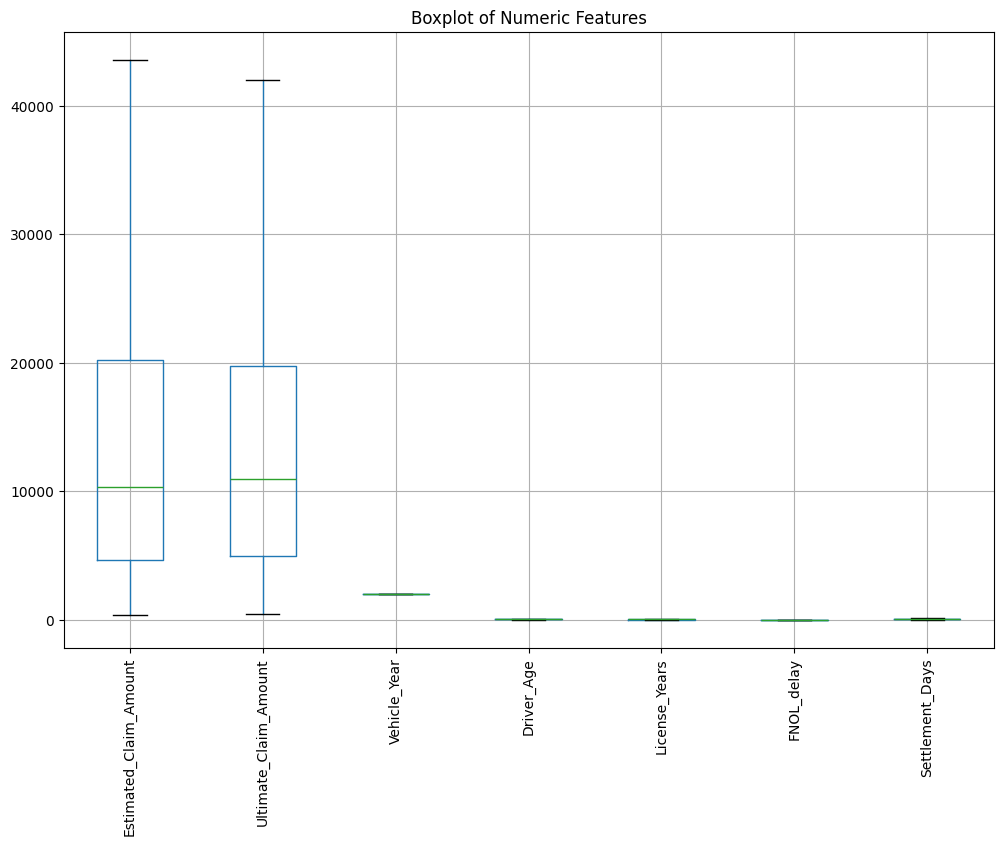

In [36]:
#validate winsorization
for col in numeric_features:
    iqr_outliers[col] = get_iqr_outliers(claims_df, col)

print(iqr_outliers.sum())

plt.figure(figsize=(12,8))
claims_df[numeric_features].boxplot(rot=90)
plt.title('Boxplot of Numeric Features')
plt.show()

Addressing the Skewedness of the target variable

In [37]:
claims_df['Ultimate_Claim_Amount'] = np.log1p(claims_df['Ultimate_Claim_Amount'])

Feature Selection

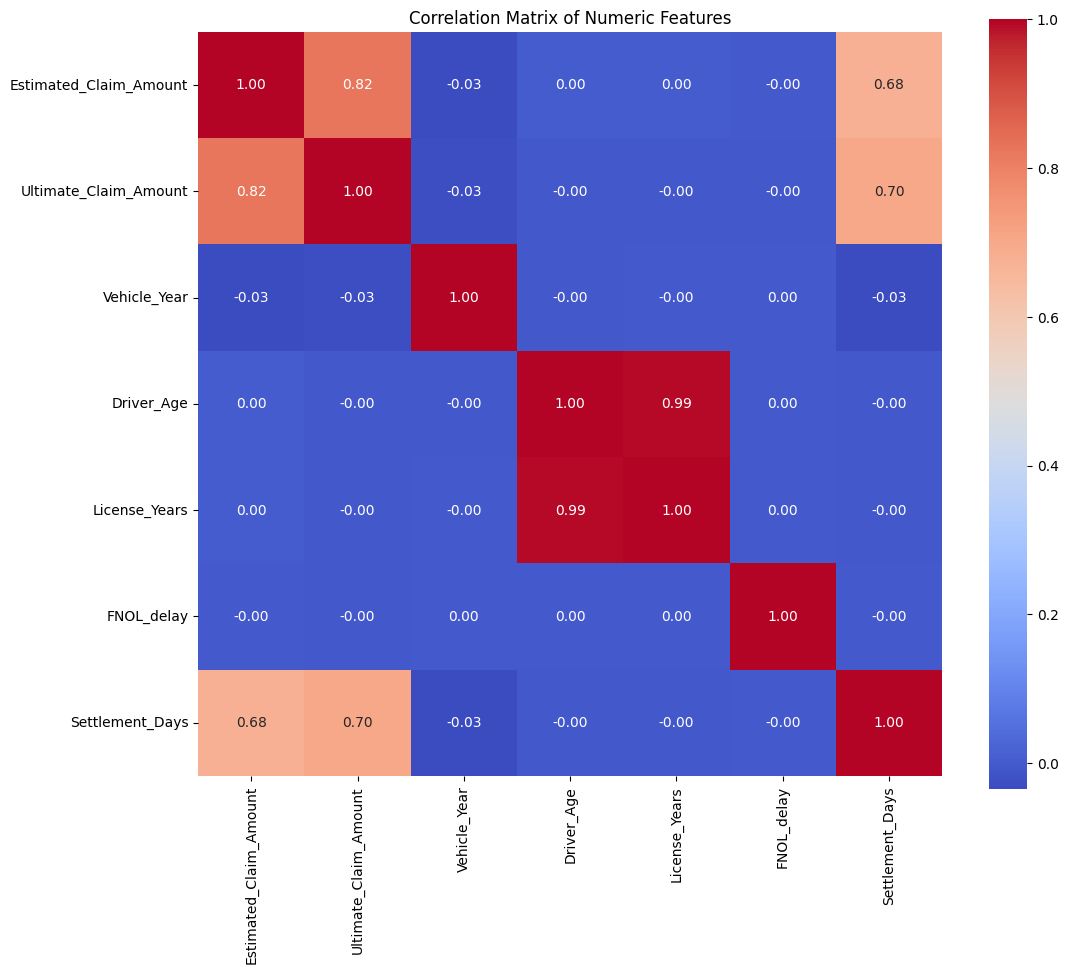

In [38]:
numeric_features = claims_df.select_dtypes(include=['int64', 'float64']).columns

# compute correlation matrix
corr_matrix = claims_df[numeric_features].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [39]:
features = ['Claim_Type', 
            'Estimated_Claim_Amount',
            'Traffic_Condition',
            'Weather_Condition',
            'Driver_Age',
            'License_Years',
            'Vehicle_Type',
            'Vehicle_Year']

target = ['Ultimate_Claim_Amount']

In [40]:
claims_df = claims_df[features + target]

In [41]:
# claims_df['Ultimate_Claim_Amount'].isnull().sum()

In [42]:
# valid_indices = claims_df[claims_df['Ultimate_Claim_Amount'].notnull()].index
# claims_df = claims_df.loc[valid_indices].reset_index(drop=True)

In [43]:
claims_df.shape

(146987, 9)

In [44]:
print(claims_df.columns.to_series().reset_index(drop=True))

0                Claim_Type
1    Estimated_Claim_Amount
2         Traffic_Condition
3         Weather_Condition
4                Driver_Age
5             License_Years
6              Vehicle_Type
7              Vehicle_Year
8     Ultimate_Claim_Amount
dtype: object


In [45]:
# Identify numeric and categorical features
numeric_features = claims_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('Ultimate_Claim_Amount')
categorical_features = claims_df.select_dtypes(include=['object']).columns.tolist()

# define numeric pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# define categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
]).set_output(transform="pandas")

# apply preprocessing to the claims dataframe

claims_df_processed = preprocessor.fit_transform(claims_df)

print("Original shape of claims_df:", claims_df.shape)
print("Processed shape of claims_df:", claims_df_processed.shape)

Original shape of claims_df: (146987, 9)
Processed shape of claims_df: (146987, 26)


In [46]:
claims_df_processed.head()

,num__Estimated_Claim_Amount,num__Driver_Age,num__License_Years,num__Vehicle_Year,cat__Claim_Type_animal_collision,cat__Claim_Type_bodily_injury,cat__Claim_Type_collision,cat__Claim_Type_fire,cat__Claim_Type_glass,cat__Claim_Type_theft,...,cat__Weather_Condition_Foggy,cat__Weather_Condition_Rainy,cat__Weather_Condition_Snowy,cat__Weather_Condition_Stormy,cat__Vehicle_Type_Hatchback,cat__Vehicle_Type_Minivan,cat__Vehicle_Type_SUV,cat__Vehicle_Type_Sedan,cat__Vehicle_Type_Sports_Car,cat__Vehicle_Type_Truck
0,-0.453884,-0.831782,-0.744231,-0.775585,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.133861,-0.831782,-0.799520,-0.083084,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.149167,0.002276,0.195683,1.475043,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.919995,-0.053328,0.140394,1.475043,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.126612,0.002276,0.195683,1.475043,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(claims_df_processed, claims_df[target].values, test_size=0.2, random_state=42)

### Model Development

1. Random Forest Regressor
2. Linear Regression
3. Hist Gradient Boosting Regressor

In [48]:
# initialize RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# initialize Linear Regression model
linear_model = LinearRegression()

# initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)


In [49]:
# fit RandomForestRegressor model
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [50]:
# fit Linear Regression model
linear_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [51]:
# fit Gradient Boosting Regressor model
gb_model.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [52]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = round(root_mean_squared_error(y_test, y_pred), 2)
    mae = round(mean_absolute_error(y_test, y_pred), 2)
    r2 = round(r2_score(y_test, y_pred), 2)
    return rmse, mae, r2

In [53]:
random_forest_results = evaluate_model(rf_model, X_test, y_test)
linear_regression_results = evaluate_model(linear_model, X_test, y_test)
gb_results = evaluate_model(gb_model, X_test, y_test)
print("=" * 50)
print("Random Forest Regressor Results")
print("RSME", random_forest_results[0])
print("MAE", random_forest_results[1])
print("R2", random_forest_results[2])
print("\n" + "=" * 50)

print("Linear Regression Results")
print("RSME", linear_regression_results[0])
print("MAE", linear_regression_results[1])
print("R2", linear_regression_results[2]) 
print("\n" + "=" * 50)

print("Gradient Boosting Regressor Results")
print("RSME", gb_results[0])
print("MAE", gb_results[1])
print("R2", gb_results[2])
print("\n" + "=" * 50)

Random Forest Regressor Results
RSME 0.27
MAE 0.18
R2 0.93

Linear Regression Results
RSME 0.4
MAE 0.31
R2 0.86

Gradient Boosting Regressor Results
RSME 0.27
MAE 0.18
R2 0.93



### Model Hyperparameter Tuning

In [54]:
# Define hyperparameter grid for Random Forest
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring='r2',
    n_jobs=-1,  # use all processors
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV R² score:", round(random_search.best_score_, 4))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Best CV R² score: 0.9338


In [55]:
# Get the best model from RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Evaluate the tuned model
tuned_rmse, tuned_mae, tuned_r2 = evaluate_model(best_rf_model, X_test, y_test)

print("=" * 50)
print("Tuned Random Forest Regressor Results")
print("RMSE:", tuned_rmse)
print("MAE:", tuned_mae)
print("R²:", tuned_r2)
print("=" * 50)

# Compare with original model
print("\nComparison:")
print(f"Original RF - RMSE: {random_forest_results[0]}, MAE: {random_forest_results[1]}, R²: {random_forest_results[2]}")
print(f"Tuned RF - RMSE: {tuned_rmse}, MAE: {tuned_mae}, R²: {tuned_r2}")

Tuned Random Forest Regressor Results
RMSE: 0.27
MAE: 0.19
R²: 0.93

Comparison:
Original RF - RMSE: 0.27, MAE: 0.18, R²: 0.93
Tuned RF - RMSE: 0.27, MAE: 0.19, R²: 0.93


GridsearchCV Ridge hyperparameter tuning for linear regression

In [56]:
# Define hyperparameter grid for Ridge Regression
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Initialize GridSearchCV with Ridge
grid_search_ridge = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',
    n_jobs=-1
)

# Fit GridSearchCV
grid_search_ridge.fit(X_train, y_train)

print("Best parameters:", grid_search_ridge.best_params_)
print("Best CV R² score:", round(grid_search_ridge.best_score_, 4))

# Get the best model
best_ridge_model = grid_search_ridge.best_estimator_

# Evaluate
tuned_rmse, tuned_mae, tuned_r2 = evaluate_model(best_ridge_model, X_test, y_test)
print("=" * 50)
print("Best Ridge Model Results")
print("RMSE:", tuned_rmse)
print("MAE:", tuned_mae)
print("R²:", tuned_r2)
print("=" * 50)

# compare with original Linear Regression model
print("\nComparison:")
print(f"Original Linear Regression - RMSE: {linear_regression_results[0]}, MAE: {linear_regression_results[1]}, R²: {linear_regression_results[2]}")
print(f"Best Ridge Model - RMSE: {tuned_rmse}, MAE: {tuned_mae}, R²: {tuned_r2}")

Best parameters: {'alpha': 1}
Best CV R² score: 0.8564
Best Ridge Model Results
RMSE: 0.4
MAE: 0.31
R²: 0.86

Comparison:
Original Linear Regression - RMSE: 0.4, MAE: 0.31, R²: 0.86
Best Ridge Model - RMSE: 0.4, MAE: 0.31, R²: 0.86


Gridsearch Lasso Hyperparameter tuning for linear regression

In [57]:
# Define hyperparameter grid for Lasso
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

grid_search_lasso = GridSearchCV(
    estimator=Lasso(max_iter=5000),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search_lasso.fit(X_train, y_train)

print("Best parameters:", grid_search_lasso.best_params_)
print("Best CV R² score:", round(grid_search_lasso.best_score_, 4))

best_lasso_model = grid_search_lasso.best_estimator_
tuned_rmse, tuned_mae, tuned_r2 = evaluate_model(best_lasso_model, X_test, y_test)
print("=" * 50)
print("Best Lasso Model Results")
print("RMSE:", tuned_rmse)
print("MAE:", tuned_mae)
print("R²:", tuned_r2)
print("=" * 50)

print("\nComparison:")
print(f"Original Linear Regression - RMSE: {linear_regression_results[0]}, MAE: {linear_regression_results[1]}, R²: {linear_regression_results[2]}")
print(f"Best Lasso Model - RMSE: {tuned_rmse}, MAE: {tuned_mae}, R²: {tuned_r2}")

Best parameters: {'alpha': 0.0001}
Best CV R² score: 0.8564
Best Lasso Model Results
RMSE: 0.4
MAE: 0.31
R²: 0.86

Comparison:
Original Linear Regression - RMSE: 0.4, MAE: 0.31, R²: 0.86
Best Lasso Model - RMSE: 0.4, MAE: 0.31, R²: 0.86


RandomizedSearchCV hyperparameter tuning for Gradient boosting model

In [58]:
# Define hyperparameter grid for Gradient Boosting
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None],
    'loss': ['squared_error', 'absolute_error', 'huber']
}

# Initialize RandomizedSearchCV
random_search_gb = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring='r2',
    n_jobs=-1,  # use all processors
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV
random_search_gb.fit(X_train, y_train)

print("Best parameters:", random_search_gb.best_params_)
print("Best CV R² score:", round(random_search_gb.best_score_, 4))

# Get the best model
best_gb_model = random_search_gb.best_estimator_

# Evaluate the tuned model
tuned_rmse, tuned_mae, tuned_r2 = evaluate_model(best_gb_model, X_test, y_test)

print("=" * 50)
print("Tuned Gradient Boosting Regressor Results")
print("RMSE:", tuned_rmse)
print("MAE:", tuned_mae)
print("R²:", tuned_r2)
print("=" * 50)

# Compare with original model
print("\nComparison:")
print(f"Original GB - RMSE: {gb_results[0]}, MAE: {gb_results[1]}, R²: {gb_results[2]}")
print(f"Tuned GB - RMSE: {tuned_rmse}, MAE: {tuned_mae}, R²: {tuned_r2}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.9, 'n_estimators': 250, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 3, 'loss': 'squared_error', 'learning_rate': 0.2}
Best CV R² score: 0.9362
Tuned Gradient Boosting Regressor Results
RMSE: 0.26
MAE: 0.18
R²: 0.94

Comparison:
Original GB - RMSE: 0.27, MAE: 0.18, R²: 0.93
Tuned GB - RMSE: 0.26, MAE: 0.18, R²: 0.94


### MLFlow Model Tracking

In [59]:
mlflow.set_tracking_uri("file:///C:/Users/mrdan/Documents/Data_Science_Notes/Machine_Learning/amdari/FNOL_claims_intelligence_system/mlruns")

In [60]:
mlflow.set_experiment("FNOL_Claims_Intelligence_System")

<Experiment: artifact_location='file:///C:/Users/mrdan/Documents/Data_Science_Notes/Machine_Learning/amdari/FNOL_claims_intelligence_system/mlruns/201630350189136410', creation_time=1765970672497, experiment_id='201630350189136410', last_update_time=1765970672497, lifecycle_stage='active', name='FNOL_Claims_Intelligence_System', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [61]:
mlflow.get_tracking_uri()

'file:///C:/Users/mrdan/Documents/Data_Science_Notes/Machine_Learning/amdari/FNOL_claims_intelligence_system/mlruns'

In [62]:
models = {
    'Random_Forest': rf_model,
    'Tuned_Random_Forest': best_rf_model,
    'Linear_Regression': linear_model,
    'Best_Ridge': best_ridge_model,
    'Best_Lasso': best_lasso_model,
    'Gradient_Boosting': gb_model,
    'Tuned_Gradient_Boosting': best_gb_model    
}

In [63]:
for model_name, model in models.items():
    with mlflow.start_run(run_name = model_name):

        # log model hyperparameters
        if hasattr(model, 'get_params'):
            mlflow.log_params(model.get_params())

        model_pred_log = model.predict(X_test)
        preds = np.expm1(model_pred_log)


        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        mlflow.log_metrics({
            'MAE': mae,
            'MSE': mse,
            'R2_Score': r2
        })

        mlflow.sklearn.log_model(model, model_name)

print("Models and metrics logged to MLflow.")

2025/12/24 11:49:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/24 11:50:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/24 11:50:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/24 11:50:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/24 11:50:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/24 11:50:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/24 11:50:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Models and metrics logged to MLflow.


### SHAP & LIME for model explainability

In [64]:
best_model = best_rf_model

100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


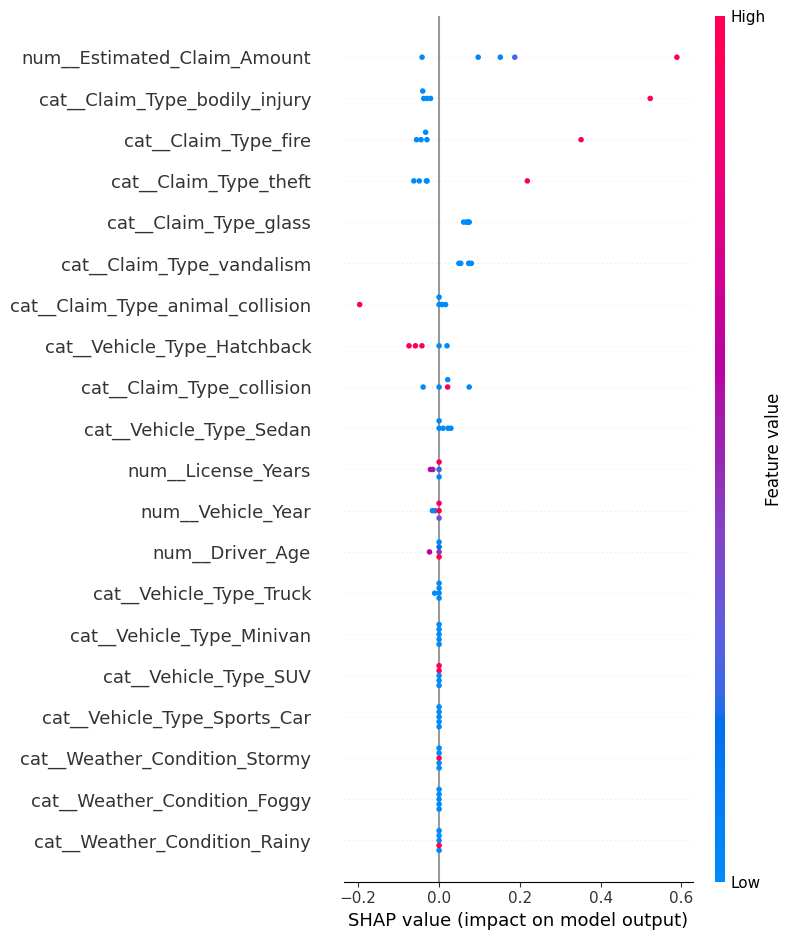

In [65]:
# create a wrapper function for the model prediction
def pipeline_predict(X):
    # X is expected to be a numpy array for SHAP
    return best_model.predict(X)

# use smaller background dataset
X_background = shap.sample(X_train, 100)
X_test_sample_small = X_test[:5]

# Use KernelExplainer with the wrapper function
explainer = shap.KernelExplainer(pipeline_predict, X_background)
shap_values = explainer.shap_values(X_test_sample_small)

# Plot results
shap.summary_plot(shap_values, X_test_sample_small)


Feature Importance

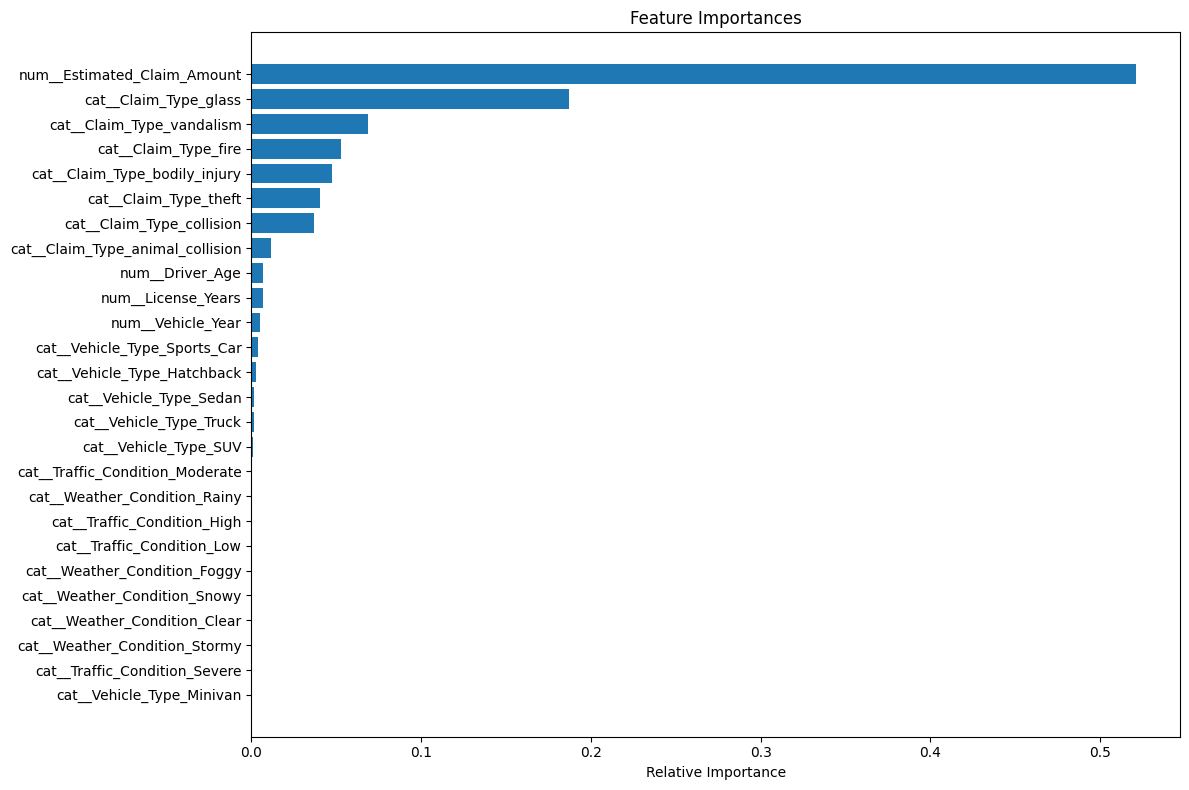

In [66]:
model = best_rf_model
feature_names = X_train.columns

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()


Saving the best model

In [67]:
# save it locally  for deployment
os.makedirs('models', exist_ok=True)
joblib.dump(best_rf_model, 'models/best_random_forest_model.pkl')

print("Model saved successfully.")

Model saved successfully.


In [68]:
feature_columns = X_train.columns.to_list()

with open('models/feature_columns.pkl', 'wb') as f:
    joblib.dump(feature_columns, f)